In [1]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import torch
from tqdm import tqdm
import numpy as np

In [2]:
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)
DATA_DIR_PATH = './data_analyze/processed_data/val'

In [3]:
image_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

dataset = ImageFolder(root=DATA_DIR_PATH, transform=image_transforms)

dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=8)

# Confusion matrix

/tmp/ipykernel_54985/4031501664.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet50 = torch.load('fine_tuned_resnet_30_10_2024_02_46_26.pt', map_location=torch.devi

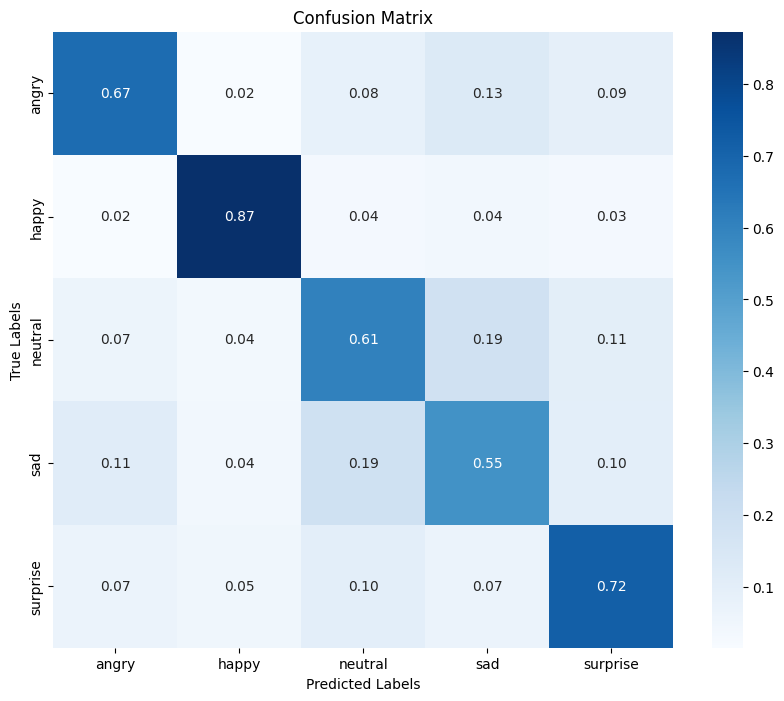

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet50 = torch.load('fine_tuned_resnet_30_10_2024_02_46_26.pt', map_location=torch.device(device))

resnet50 = resnet50.to(device)

resnet50.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
  for inputs, labels in tqdm(dataloader):
    inputs = inputs.to(device)
    outputs = resnet50(inputs)
    _, preds = torch.max(outputs, 1)

    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(preds.cpu().numpy())


cm = confusion_matrix(true_labels, pred_labels)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig('conf_matrix_fine_tuned_resnet_30_10_2024_02_46_26.png')
plt.show()

# Training visualization

In [2]:
TRAIN_RESULTS_PATH = 'metrics-train.txt' 
TEST_RESULTS_PATH = 'metrics-test.txt'

In [19]:
def visualize_training(data_path, output_path, type):
    epochs = []
    losses = []
    accuracies = []

    with open(data_path, 'r') as file:
        for epoch, line in enumerate(file):
            if 'epoch' in line:
                loss_idx = line.find(':')
                acc_idx = line.rfind(':')
                loss = float(line[loss_idx + 2:acc_idx - 4])
                acc = float(line[acc_idx + 2:])
                epochs.append(epoch + 1)
                losses.append(loss)
                accuracies.append(acc)
    print(losses)
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, marker='o', color='b', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{type} Loss per Epoch')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))


    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, marker='o', color='g', label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{type} Accuracy per Epoch')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()


[1.6162, 1.5731, 1.5532, 1.5083, 1.3804, 1.287, 1.2083, 1.118, 1.0814, 1.0609, 1.0389, 1.0204, 1.0, 0.9841, 0.9726, 0.9685, 0.9647, 0.9542, 0.9499, 0.9569]


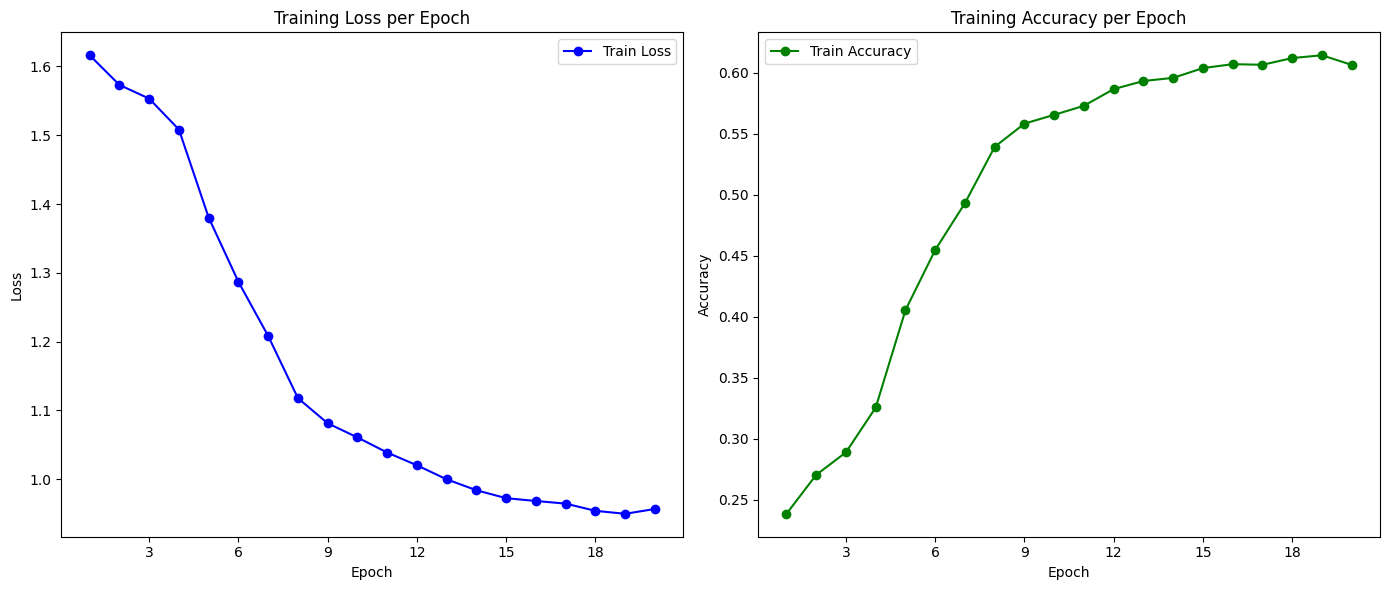

In [22]:
visualize_training(TRAIN_RESULTS_PATH, 'metrics-training.png', 'Training')

[1.5717, 1.5522, 1.5671, 1.4129, 1.2834, 1.1263, 1.135, 0.9685, 0.9544, 0.9321, 0.8822, 0.869, 0.8404, 0.8324, 0.8186, 0.8116, 0.8147, 0.8072, 0.8063, 0.8081]


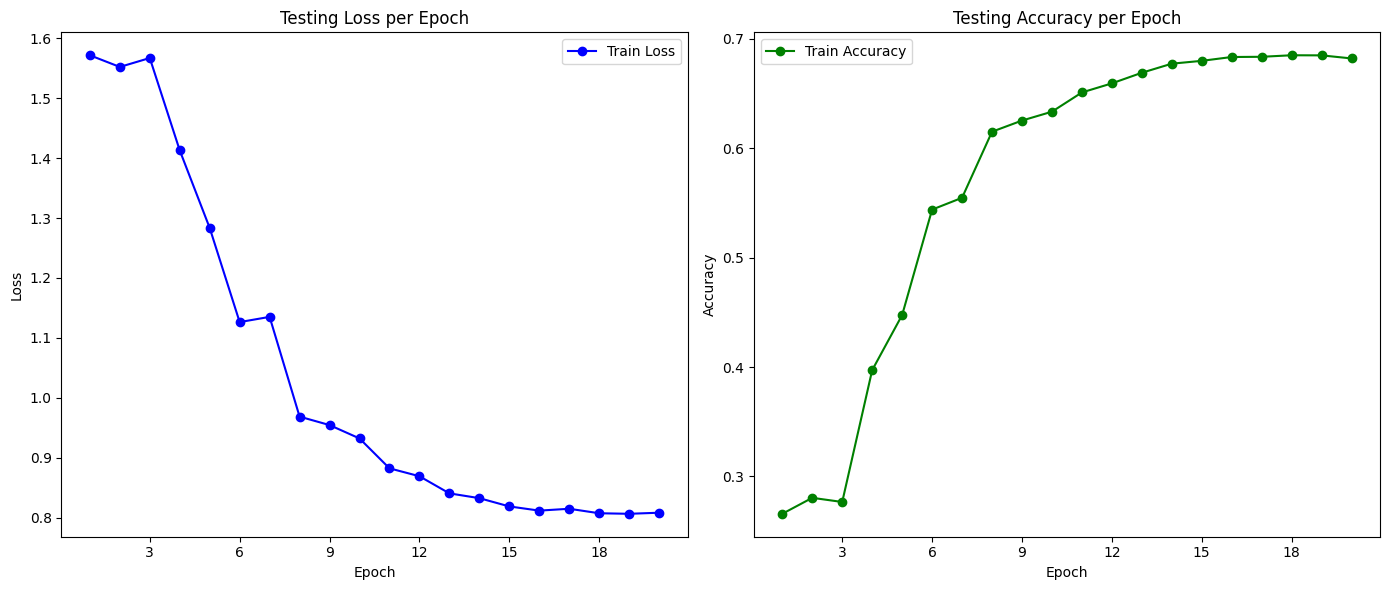

In [23]:
visualize_training(TEST_RESULTS_PATH, 'metrics-test.png', 'Testing')